In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

#ee.Initialize()

In [3]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']].reset_index()

dfs

,index,Station Code,Station Name,Latitude,Longitude
0,0,acebbnut,Big Bay,32.49410,-80.32410
1,3,acefcnut,Fishing Creek,32.63593,-80.36556
2,5,acemcnut,Mosquito Creek,32.55580,-80.43800
3,8,acespnut,St. Pierre,32.52800,-80.36144
4,11,aceeinut,Edisto Island,32.50400,-80.32470
...,...,...,...,...,...
147,340,wkbwsnut,Weather Station,30.41481,-87.82600
148,344,wqbcrnut,Childs River,41.57980,-70.53090
149,347,wqbmhnut,Menauhant,41.55260,-70.54850
150,349,wqbmpnut,Metoxit Point,41.56890,-70.52160


In [4]:
dfx = dfs[dfs['Station Code']=='delslnut  '] #two spaces put in after each code for some stupid fucking reason

# dfs.iloc[0,0]

dfx

# dfx.iloc[0,3]

,index,Station Code,Station Name,Latitude,Longitude
32,68,delslnut,Scotton Landing,39.08498,-75.46058


In [5]:
px = ee.Geometry.Point([dfx.iloc[0,4], dfx.iloc[0,3]])
#lon and lat

Map = geemap.Map(center=[38.7813,-76.7137], zoom=16)

# Map

In [6]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

# vcr_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/VCR domain/VCR_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)


bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])


In [7]:
del_nut = geemap.shp_to_ee('F:/Wetlands shapefiles/NERR veg polygons/Delaware/delslnut_polygon.shp')


In [8]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(2003, 2024,'year')).map(lambda image: image.clip(del_nut)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [9]:
def area_extract(image):
    
    feature = image.sampleRegions(
        collection=del_nut,
        scale=30,
        geometries=True)
    
    return feature

In [10]:
im_list = ultra.toList(ultra.size())

In [11]:
ultra.first()

In [12]:
#Extract time series for nutrient station

feature_list = ultra.map(area_extract).flatten().toList(ultra.size())
values_list = []

# Loop through the feature list and extract values
for i in range(feature_list.size().getInfo()):
    feature = ee.Feature(feature_list.get(i))
    properties = feature.toDictionary()
    values_list.append(properties.getInfo())

# Convert the list of dictionaries to a pandas DataFrame
timeseries_df = pd.DataFrame(values_list)

# Print the DataFrame
print(timeseries_df)

KeyboardInterrupt: 

In [12]:
timeseries_df

NameError: name 'timeseries_df' is not defined

In [13]:
import os
out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/NERR data/')
out_csv = os.path.join(out_dir, 'timeseries_de.csv')
# timeseries_df.to_csv(out_csv, index = False)

In [14]:
timeseries_df = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/timeseries_de.csv')

In [15]:
timeseries_df['Date'] = pd.to_datetime(timeseries_df['acquisition_date'], unit = 'ms')
timeseries_df['DOY'] = timeseries_df['Date'].dt.strftime('%Y-%m-%d')
timeseries_df['DOY'] = pd.to_datetime(timeseries_df['DOY'])

timeseries_df

,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,ST_URAD,Shape_Area,Shape_Leng,acquisition_date,flats,SR_B6,SR_QA_AEROSOL,ST_B10,Date,DOY
0,5440,0,420.0,0.033062,0.058225,0.046235,0.316972,0.114875,0.048050,1.0,...,3041,7.921311e-07,0.010045,1061824646025,0.000007,NaN,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25
1,5440,0,421.0,0.035400,0.053495,0.046207,0.236095,0.126095,0.044062,1.0,...,3041,7.921311e-07,0.010045,1061824646025,0.000031,NaN,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25
2,5440,0,421.0,0.037738,0.053495,0.042467,0.278775,0.128900,0.040075,1.0,...,3041,7.921311e-07,0.010045,1061824646025,0.000004,NaN,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25
3,5440,0,421.0,0.030642,0.053495,0.046152,0.287272,0.100822,0.044062,1.0,...,3041,7.921311e-07,0.010045,1061824646025,0.000030,NaN,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25
4,5440,0,421.0,0.033007,0.053468,0.042440,0.270278,0.109265,0.044062,1.0,...,3041,7.921311e-07,0.010045,1061824646025,0.000014,NaN,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,21824,0,NaN,0.024125,0.030147,0.052422,0.049370,0.245362,0.075605,NaN,...,2084,7.921311e-07,0.010045,1379778131450,0.000071,0.163825,96.0,299.420224,2013-09-21 15:42:11.450,2013-09-21
516,21824,0,NaN,0.023355,0.029130,0.049837,0.049618,0.203260,0.060205,NaN,...,2084,7.921311e-07,0.010045,1379778131450,0.000606,0.121640,96.0,300.233713,2013-09-21 15:42:11.450,2013-09-21
517,21824,0,NaN,0.017662,0.024427,0.051955,0.047940,0.220640,0.062955,NaN,...,2084,7.921311e-07,0.010045,1379778131450,0.000254,0.133465,66.0,300.257639,2013-09-21 15:42:11.450,2013-09-21
518,21824,0,NaN,0.013455,0.020990,0.046785,0.041258,0.210437,0.053330,NaN,...,2084,7.921311e-07,0.010045,1379778131450,0.000286,0.111850,96.0,300.486646,2013-09-21 15:42:11.450,2013-09-21


<AxesSubplot:xlabel='Date', ylabel='flats'>

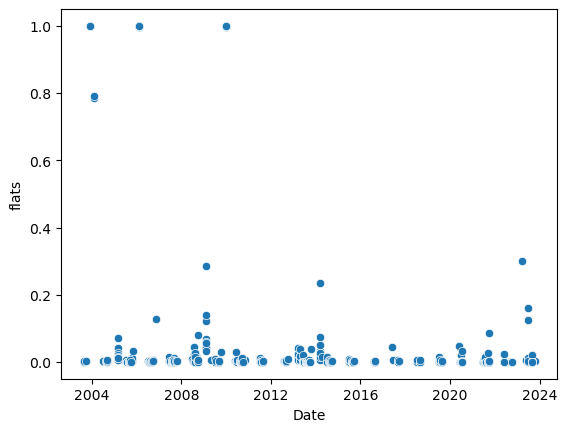

In [16]:
import seaborn as sns
sns.scatterplot(data = timeseries_df, x = 'Date', y = 'flats')

##NOTE: NUTRIENT STATION IS ON DOCK IN MIDDLE OF CREEK _ FLATS WILL NOT BE ACCURATE HERE __ NEED AREA

In [15]:
##LANDSAT ACQUISITION TIME!!! FOR TIDE/TIME MERGING

In [17]:
#Tides -- DE (is this close enough to where NERR station is? check tide gauge location)

path = r'C:/Users/arj26323/Documents/Data/Tide data/DE_tides_8537121' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

time_mask = (df2['Time (GMT)'].dt.hour == 16)
de_time = df2[time_mask]

de_time['Verified (m)'] = de_time['Verified (m)'].replace('-', float('nan')).astype('float')

de_time

##Combine time/tide and flats data
df_combined = pd.merge(timeseries_df, de_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,SR_QA_AEROSOL,ST_B10,Date_x,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,5440,0,420.0,0.033062,0.058225,0.046235,0.316972,0.114875,0.048050,1.0,...,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25,2003/08/25,2024-05-21 16:00:00,0.884,-,0.818,2003-08-25 15:17:26.025
1,5440,0,421.0,0.035400,0.053495,0.046207,0.236095,0.126095,0.044062,1.0,...,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25,2003/08/25,2024-05-21 16:00:00,0.884,-,0.818,2003-08-25 15:17:26.025
2,5440,0,421.0,0.037738,0.053495,0.042467,0.278775,0.128900,0.040075,1.0,...,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25,2003/08/25,2024-05-21 16:00:00,0.884,-,0.818,2003-08-25 15:17:26.025
3,5440,0,421.0,0.030642,0.053495,0.046152,0.287272,0.100822,0.044062,1.0,...,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25,2003/08/25,2024-05-21 16:00:00,0.884,-,0.818,2003-08-25 15:17:26.025
4,5440,0,421.0,0.033007,0.053468,0.042440,0.270278,0.109265,0.044062,1.0,...,NaN,NaN,2003-08-25 15:17:26.025,2003-08-25,2003/08/25,2024-05-21 16:00:00,0.884,-,0.818,2003-08-25 15:17:26.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,21824,0,NaN,0.024125,0.030147,0.052422,0.049370,0.245362,0.075605,NaN,...,96.0,299.420224,2013-09-21 15:42:11.450,2013-09-21,2013/09/21,2024-05-21 16:00:00,2.076,-,2.202,2013-09-21 15:42:11.450
516,21824,0,NaN,0.023355,0.029130,0.049837,0.049618,0.203260,0.060205,NaN,...,96.0,300.233713,2013-09-21 15:42:11.450,2013-09-21,2013/09/21,2024-05-21 16:00:00,2.076,-,2.202,2013-09-21 15:42:11.450
517,21824,0,NaN,0.017662,0.024427,0.051955,0.047940,0.220640,0.062955,NaN,...,66.0,300.257639,2013-09-21 15:42:11.450,2013-09-21,2013/09/21,2024-05-21 16:00:00,2.076,-,2.202,2013-09-21 15:42:11.450
518,21824,0,NaN,0.013455,0.020990,0.046785,0.041258,0.210437,0.053330,NaN,...,96.0,300.486646,2013-09-21 15:42:11.450,2013-09-21,2013/09/21,2024-05-21 16:00:00,2.076,-,2.202,2013-09-21 15:42:11.450


<AxesSubplot:xlabel='Verified (m)', ylabel='flats'>

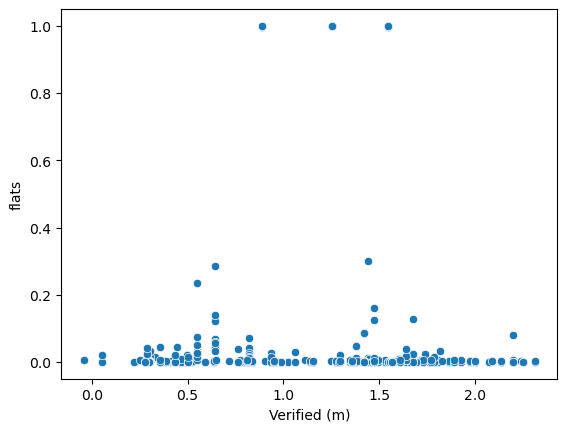

In [18]:
import seaborn as sns

sns.scatterplot(data = df_combined, x = 'Verified (m)', y = 'flats') #Not good at all

In [19]:
# sns.scatterplot(data = df_combined, x = 'Verified (m)', y = 'flats') #This relationship needs to be much better - mixed pixel?

In [29]:
##Adding nutrient data

##CBMRR station
path = r'C:/Users/arj26323/Documents/Data/NERR data/Files 2024' #changed from Files folder 4/25/24
all_files = glob.glob(path + "/delslnut*.csv")

li = []

for filename in all_files:
    df_sap = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_sap)

df_sap = pd.concat(li, axis=0, ignore_index=True).dropna(subset=['NO23F']).dropna(axis=1)

##Begin:
df_sap = df_sap[df_sap['NO23F'] < 0.9] ##removes several extremely large outliers
df_sap['Date_m'] = pd.to_datetime(df_sap['DateTimeStamp'])
df_sap['DOY'] = df_sap['Date_m'].dt.strftime('%Y-%m-%d')
df_sap['DOY'] = pd.to_datetime(df_sap['DOY'])

df_sap

,StationCode,isSWMP,DateTimeStamp,Historical,ProvisionalPlus,CollMethd,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY
16,delslnut,P,02/19/2002 14:00,1,1,2,1,<4>,<4>,<4>,<4> C,0.7611,<4>,<4>,2002-02-19 14:00:00,2002-02-19
17,delslnut,P,02/19/2002 16:30,1,1,2,1,<4>,<4>,<4>,<4> C,0.5988,<4>,<4>,2002-02-19 16:30:00,2002-02-19
18,delslnut,P,02/19/2002 19:00,1,1,2,1,<4>,<4>,<4>,<4> C,0.8066,<4>,<4>,2002-02-19 19:00:00,2002-02-19
21,delslnut,P,02/20/2002 2:30,1,1,2,1,<4>,<4>,<4>,<4> C,0.7393,<4>,<4>,2002-02-20 02:30:00,2002-02-20
22,delslnut,P,02/20/2002 5:00,1,1,2,1,<4>,<4>,<4>,<4> C,0.5459,<4>,<4>,2002-02-20 05:00:00,2002-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,delslnut,P,12/12/2022 20:30,0,1,2,1,<0>,<0>,<0>,<0>,0.8060,<0>,<0>,2022-12-12 20:30:00,2022-12-12
3031,delslnut,P,12/12/2022 23:00,0,1,2,1,<0>,<0>,<0>,<0>,0.7620,<0>,<0>,2022-12-12 23:00:00,2022-12-12
3032,delslnut,P,12/13/2022 1:30,0,1,2,1,<0>,<0>,<0>,<0>,0.6360,<0>,<0>,2022-12-13 01:30:00,2022-12-13
3033,delslnut,P,12/13/2022 4:00,0,1,2,1,<0>,<0>,<0>,<0>,0.6660,<0>,<0>,2022-12-13 04:00:00,2022-12-13


<AxesSubplot:xlabel='Date_m', ylabel='NO23F'>

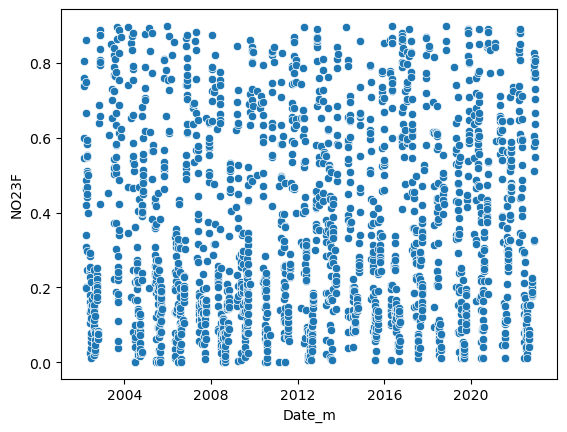

In [30]:
sns.scatterplot(data = df_sap, x = 'Date_m', y = 'NO23F')

In [31]:
##Combine nutrient data with flats and time/tide data
##Need to do merge_asof to take advantage of the large sample size for nutrient data
##Also, need to do a little pixel neighborhood, rather than a single pixel when analyzing FLATS/biomass (eventually)


# df_combined.columns = df_combined.columns.str.rstrip('_x') #remove suffix to avoid error
# df_combined2 = pd.merge(df_combined, df_sap, on = 'DOY')
# # df_combined2['Date'] = df_combined2['Date_']
# df_combined2.rename(columns={ df_combined2.columns[-1]: "Date_xxx" }, inplace = True)


##Merge, to nearest Landsat acquisition
df_combined2 = pd.merge_asof(
    df_combined.sort_values('Date'), 
    df_sap.sort_values('Date_m'), 
    left_on = 'Date',
    right_on = 'Date_m', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("1210000000ms") ##Two weeks - is this ok?
)

df_combined2


,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY_y
0,5440,0,420.0,0.033062,0.058225,0.046235,0.316972,0.114875,0.048050,1.0,...,2.0,<4>,<4>,<4>,<4> C,0.8972,<4>,<4>,2003-08-25 04:07:00,2003-08-25
1,5440,0,421.0,0.035400,0.053495,0.046207,0.236095,0.126095,0.044062,1.0,...,2.0,<4>,<4>,<4>,<4> C,0.8972,<4>,<4>,2003-08-25 04:07:00,2003-08-25
2,5440,0,421.0,0.037738,0.053495,0.042467,0.278775,0.128900,0.040075,1.0,...,2.0,<4>,<4>,<4>,<4> C,0.8972,<4>,<4>,2003-08-25 04:07:00,2003-08-25
3,5440,0,421.0,0.030642,0.053495,0.046152,0.287272,0.100822,0.044062,1.0,...,2.0,<4>,<4>,<4>,<4> C,0.8972,<4>,<4>,2003-08-25 04:07:00,2003-08-25
4,5440,0,421.0,0.033007,0.053468,0.042440,0.270278,0.109265,0.044062,1.0,...,2.0,<4>,<4>,<4>,<4> C,0.8972,<4>,<4>,2003-08-25 04:07:00,2003-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,5440,0,87.0,0.024070,0.043072,0.041395,0.134593,0.114572,0.040680,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
516,5440,0,87.0,0.024070,0.049590,0.041395,0.182305,0.107340,0.040680,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
517,5440,0,87.0,0.021072,0.039827,0.032787,0.146527,0.074725,0.029378,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
518,5440,0,87.0,0.027095,0.043100,0.032815,0.170370,0.074725,0.040680,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [32]:
len(df_combined2['NO23F'].dropna())

438

<AxesSubplot:xlabel='NO23F', ylabel='flats'>

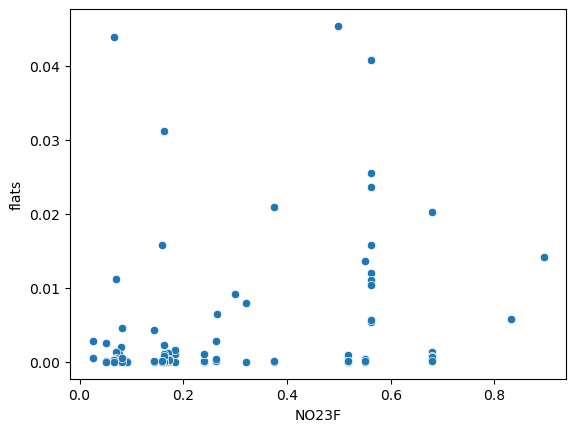

In [33]:
import seaborn as sns
import matplotlib as plt

dfz = df_combined2[df_combined2['Verified (m)'] < 0.6]

sns.scatterplot(data = dfz, x = 'NO23F', y = 'flats') ##This doesn't really tell you much. Need time + flats + N

In [34]:
print(dfz.shape)

##Tide quantiles will be different

min(dfz['Verified (m)'])

df_combined['Verified (m)'].quantile([0,.25, .5, 0.75, 1])

(140, 50)


0.00   -0.041
0.25    0.550
0.50    1.274
0.75    1.641
1.00    2.314
Name: Verified (m), dtype: float64

0.2652567983199617
Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = 0): 0.27


<Axes: xlabel='NO23F', ylabel='flats'>

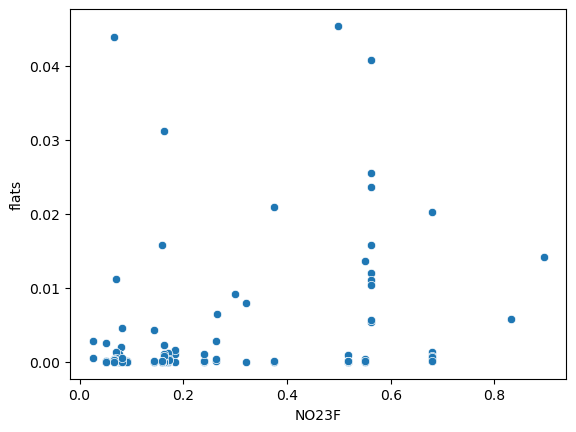

In [25]:
correlation = dfz['flats'].corr(dfz['NO23F'])
print(correlation)


##Time lag
lag = 0 #why choose this number?

no23_shifted = dfz['NO23F'].shift(-lag)

no23_shifted = no23_shifted.dropna()

# Calculate the correlation between the shifted variable and the original variable
time_lagged_corr = dfz['flats'].corr(no23_shifted)

# Print the time lagged correlation coefficient
print("Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = {}): {:.2f}".format(lag, time_lagged_corr))

sns.scatterplot(x = no23_shifted, y = dfz['flats']) ##This doesn't really tell you much. Need time + flats + N

<Axes: xlabel='Date', ylabel='flats'>

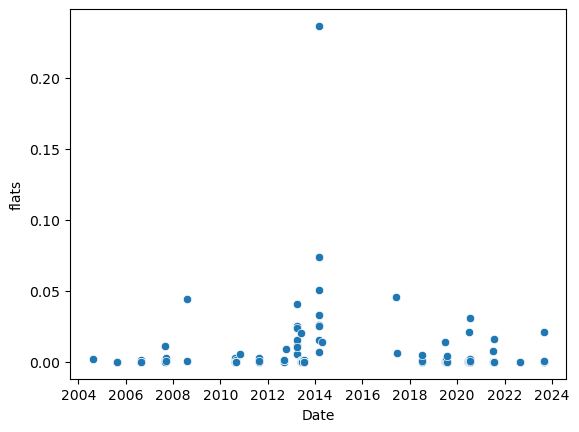

In [26]:
sns.scatterplot(data = dfz, x = 'Date', y = 'flats')

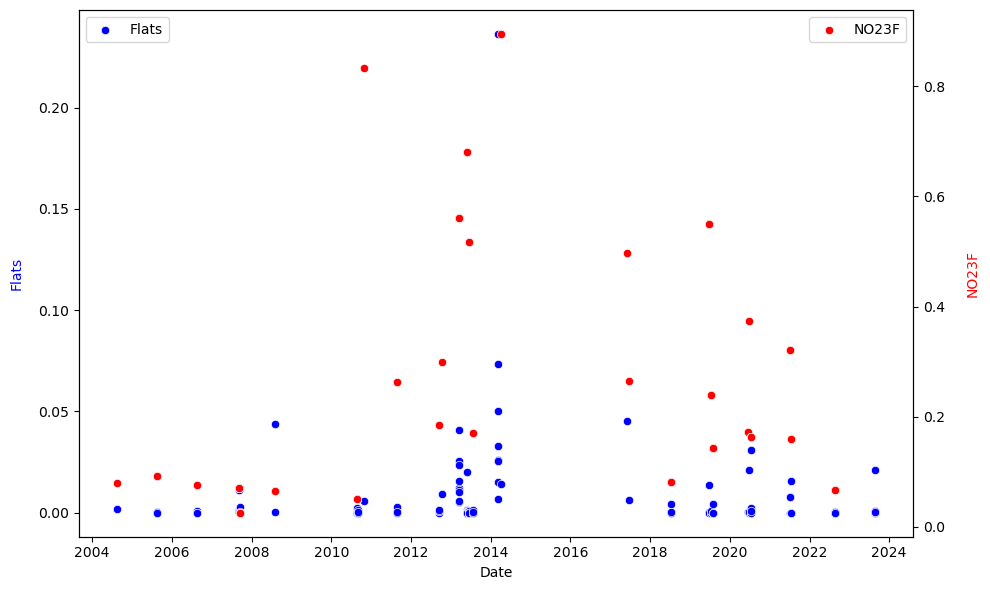

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (flats)
sns.scatterplot(ax=ax1, data=dfz, x='Date', y='flats', label='Flats', color='blue')
ax1.set_ylabel('Flats', color='blue', labelpad=10)

# Secondary y-axis (NO23F)
ax2 = ax1.twinx()  # Create a twin axis that shares the x-axis
sns.scatterplot(ax=ax2, data=dfz, x='Date', y='NO23F', label='NO23F', color='red')
ax2.set_ylabel('NO23F', color='red',  labelpad=15)

# Customize the plot further (optional)
# Place legend on primary y-axis
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')  

# Alternatively, place legend on secondary y-axis
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

In [27]:
Map = geemap.Map(center=[39.08,-75.46], zoom=15)

Map.addLayer(l5_col.first(), {'bands': ['SR_B4',  'SR_B3',  'SR_B2'], 'min': 0, 'max': 0.3}, 'Landsat 5')
Map.addLayer(l8_col.first(), {'bands': ['SR_B5',  'SR_B4',  'SR_B3'], 'min': 0, 'max': 0.2}, 'Landsat 8')

Map.addLayer(px, {}, 'NERR station')
Map.addLayer(del_nut, {}, 'polygon')

Map

Map(center=[39.08, -75.46], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [22]:
3+4

7